<a href="https://colab.research.google.com/github/thiagoparaizo/FIAP_CAP6_atv1/blob/master/ThiagoParaizo_rm566159_pbl_Fase6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# =============================================================================
# PROJETO FASE 6 - ENTREGA 1: VISÃO COMPUTACIONAL COM YOLO CUSTOMIZADO
# Detecção de Bicicletas vs Carros usando YOLOv5
# ======================================================



# 🚀 Projeto Fase 6 - Entrega 1: Sistema de Visão Computacional

## 📋 Objetivo
Desenvolver um sistema de visão computacional usando YOLOv5 customizado para
detectar e classificar **bicicletas** e **carros** em imagens.

## 🎯 Metas da Entrega
1. Dataset organizado: 80 imagens (40 bicicletas + 40 carros)
2. Divisão: 32 treino, 4 validação, 4 teste (por classe)
3. Rotulação feita no Make Sense IA
4. Treinamento com 15 e 40 épocas
5. Análise comparativa dos resultados
6. Demonstração prática com imagens de teste

---

## 📦 1. Instalação e Configuração do Ambiente

In [1]:
# Clonar repositório YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt -q

Cloning into 'yolov5'...
remote: Enumerating objects: 17611, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17611 (delta 8), reused 2 (delta 2), pack-reused 17595 (from 3)
Receiving objects: 100% (17611/17611), 16.84 MiB | 11.63 MiB/s, done.
Resolving deltas: 100% (11984/11984), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.5 MB/s eta 0:00:00


In [2]:
# Importar bibliotecas necessárias
import torch
import os
from IPython.display import Image, display
import shutil
from datetime import datetime

In [3]:
# Verificar GPU disponível
print(f'Torch version: {torch.__version__}')
print(f'CUDA disponível: {torch.cuda.is_available()}')
print(f'GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"}')

Torch version: 2.8.0+cu126
CUDA disponível: False
GPU: CPU


## 💾 2. Conexão com Google Drive e Organização do Dataset

O dataset está organizado da seguinte forma:
```
/dataset
  /train
    /images (64 imagens: 32 bicicletas + 32 carros)
    /labels (64 arquivos .txt)
  /valid
    /images (8 imagens: 4 bicicletas + 4 carros)
    /labels (8 arquivos .txt)
  /test
    /images (8 imagens: 4 bicicletas + 4 carros)
```

In [4]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Verificar estrutura do dataset
base_path = '/content/drive/MyDrive/FIAP/FASE_6/dataset'

# Verificar se o caminho existe
if os.path.exists(base_path):
    print("✅ Dataset encontrado!")
    print(f"\n📊 Estrutura do dataset:")

    # Contar imagens em cada pasta
    train_images = len(os.listdir(f'{base_path}/train/images'))
    train_labels = len(os.listdir(f'{base_path}/train/labels'))
    valid_images = len(os.listdir(f'{base_path}/valid/images'))
    valid_labels = len(os.listdir(f'{base_path}/valid/labels'))
    test_images = len(os.listdir(f'{base_path}/test/images'))

    print(f"  Train: {train_images} imagens, {train_labels} labels")
    print(f"  Valid: {valid_images} imagens, {valid_labels} labels")
    print(f"  Test: {test_images} imagens")
else:
    print("❌ Dataset não encontrado!")
    print(f"Verifique o caminho: {base_path}")

✅ Dataset encontrado!

📊 Estrutura do dataset:
  Train: 64 imagens, 64 labels
  Valid: 8 imagens, 8 labels
  Test: 8 imagens


## ⚙️ 3. Criação do Arquivo de Configuração (dataset.yaml)

Este arquivo define:
- Caminhos das pastas de treino e validação
- Número de classes (nc = 2)
- Nomes das classes (bicicleta e carro)

In [6]:
# Criar arquivo dataset.yaml
dataset_yaml_content = f"""
# Dataset configuration for YOLOv5
path: {base_path}  # Caminho raiz do dataset
train: train/images  # Caminho relativo das imagens de treino
val: valid/images    # Caminho relativo das imagens de validação

# Classes
nc: 2  # Número de classes
names: ['bicicleta', 'carro']  # Nomes das classes
"""
# Salvar arquivo yaml
yaml_path = '/content/yolov5/dataset.yaml'
with open(yaml_path, 'w') as f:
    f.write(dataset_yaml_content)

print("✅ Arquivo dataset.yaml criado com sucesso!")
print(f"\n📄 Conteúdo:")
print(dataset_yaml_content)


✅ Arquivo dataset.yaml criado com sucesso!

📄 Conteúdo:

# Dataset configuration for YOLOv5
path: /content/drive/MyDrive/FIAP/FASE_6/dataset  # Caminho raiz do dataset
train: train/images  # Caminho relativo das imagens de treino
val: valid/images    # Caminho relativo das imagens de validação

# Classes
nc: 2  # Número de classes
names: ['bicicleta', 'carro']  # Nomes das classes



# 🏋️ 4. TREINAMENTO 1: 30 ÉPOCAS

Neste primeiro treinamento, vamos treinar o modelo YOLOv5 com **15 épocas**.

### Parâmetros utilizados:
- **img**: 640 (tamanho da imagem)
- **batch**: 16 (tamanho do lote)
- **epochs**: 15
- **data**: dataset.yaml (configuração do dataset)
- **weights**: yolov5s.pt (pesos pré-treinados do YOLOv5 small)
- **cache**: Para acelerar o treinamento

In [7]:
# Treinar modelo com 30 épocas
print("🚀 Iniciando treinamento com 15 épocas...")
print(f"⏰ Início: {datetime.now().strftime('%H:%M:%S')}")

%cd /content/yolov5

!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 15 \
  --data dataset.yaml \
  --weights yolov5s.pt \
  --cache \
  --name treino_15_epocas

print(f"✅ Treinamento finalizado: {datetime.now().strftime('%H:%M:%S')}")


🚀 Iniciando treinamento com 15 épocas...
⏰ Início: 16:16:22
/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-10-20 16:16:41.163520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760977001.190015    8594 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760977001.198357    8594 cuda_blas.cc:1407] Unable to 

### 📊 Análise dos Resultados - 15 Épocas

Vamos visualizar as métricas de treinamento e alguns resultados.

📈 Gráfico de métricas de treinamento (15 épocas):


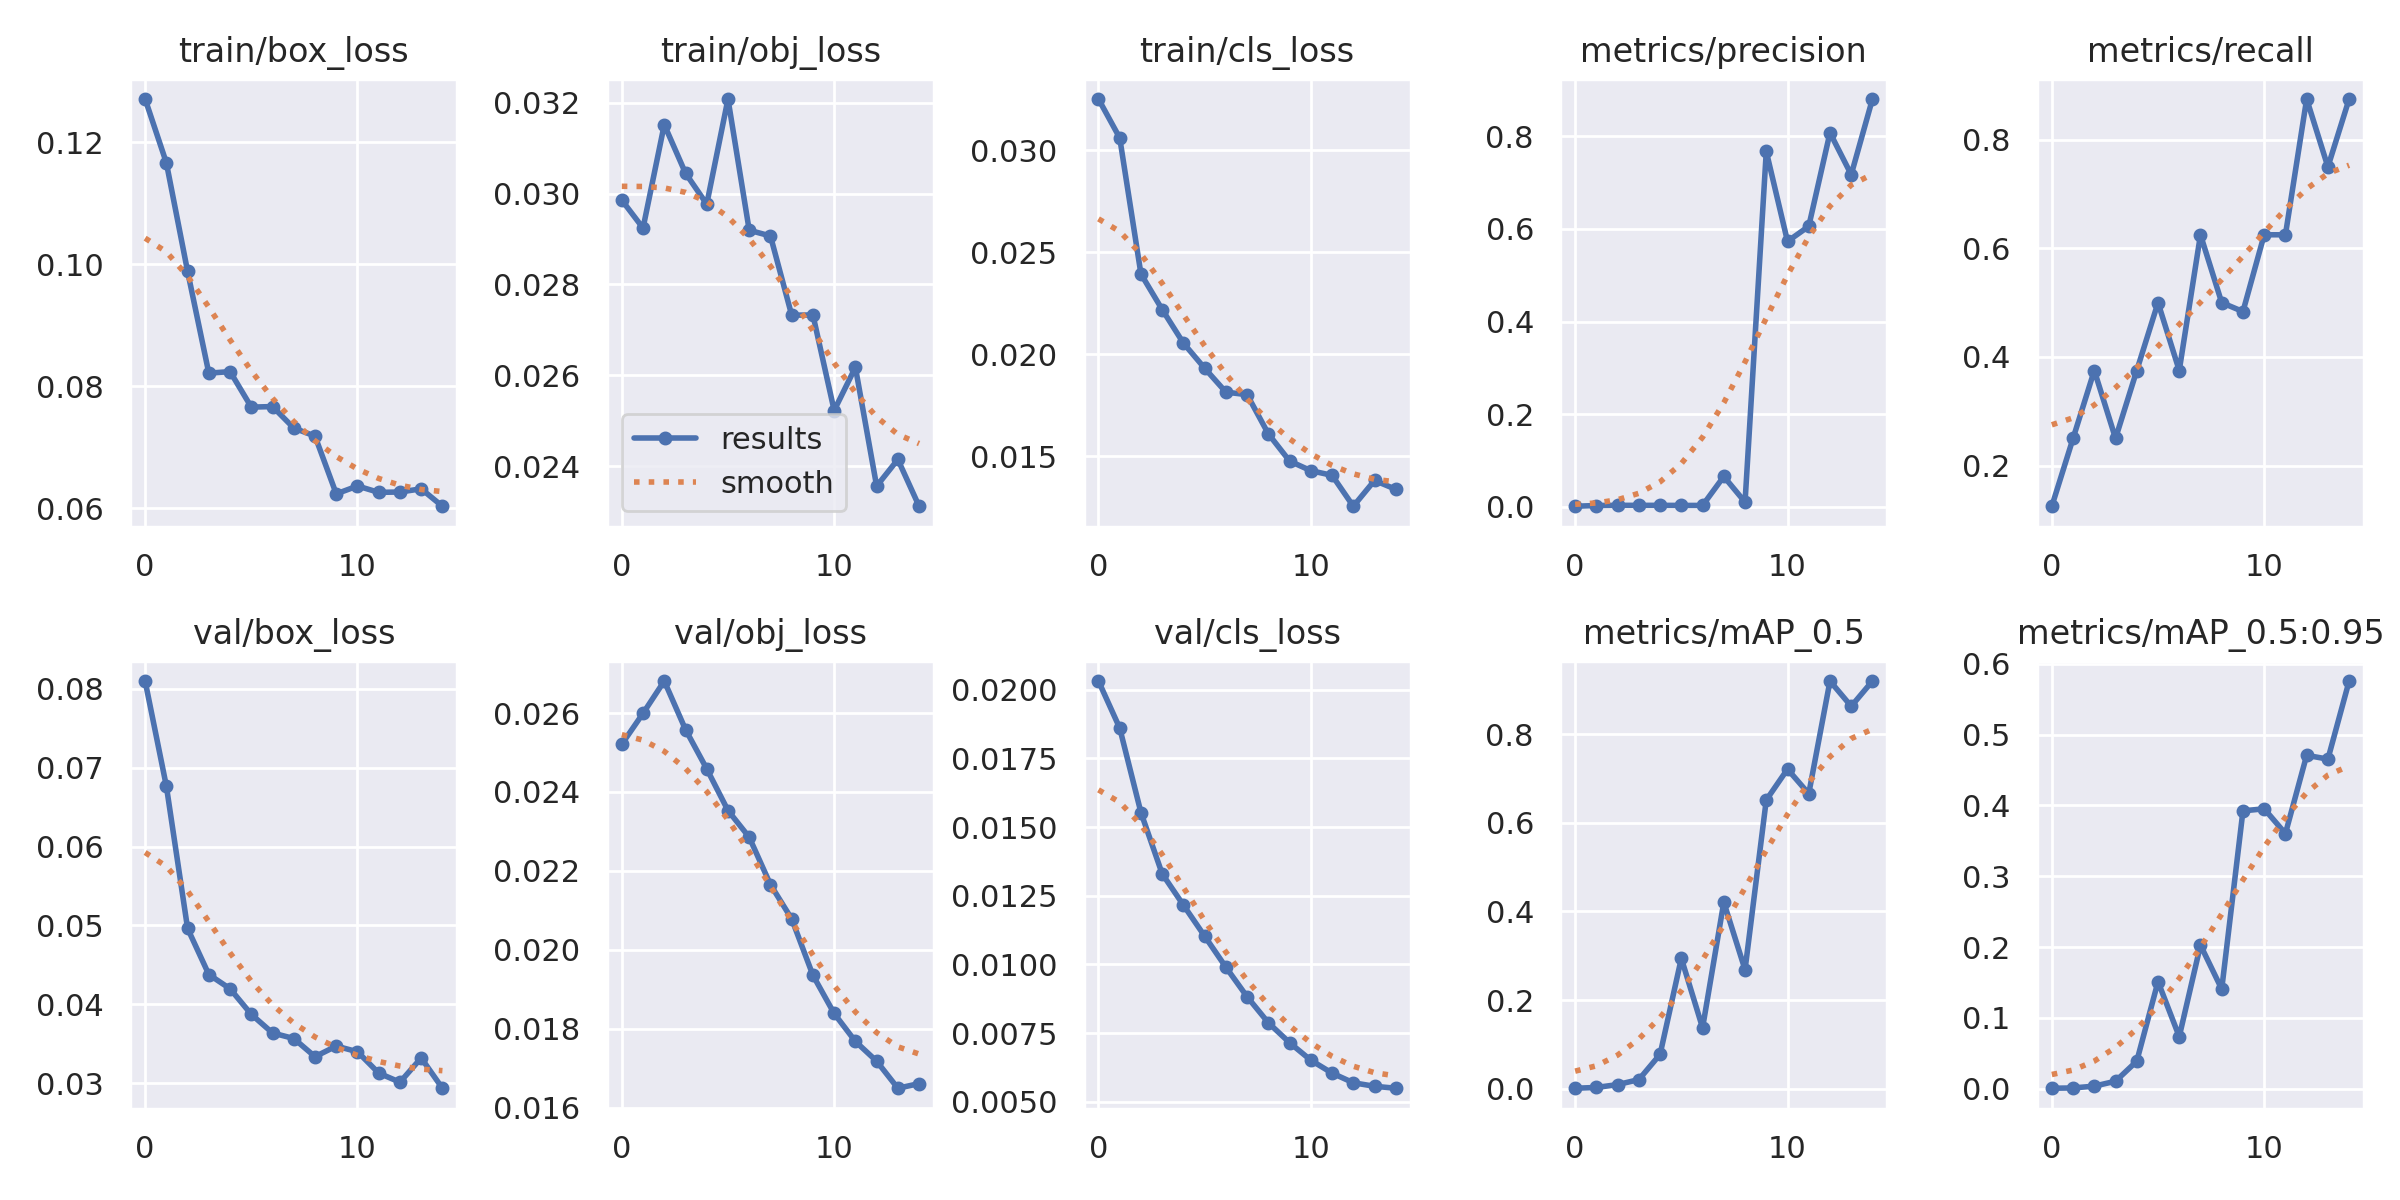

In [8]:
# Visualizar gráfico de resultados do treino (15 épocas)
print("📈 Gráfico de métricas de treinamento (15 épocas):")
display(Image(filename='/content/yolov5/runs/train/treino_15_epocas/results.png'))

🔍 Exemplos de predições no conjunto de validação (15 épocas):


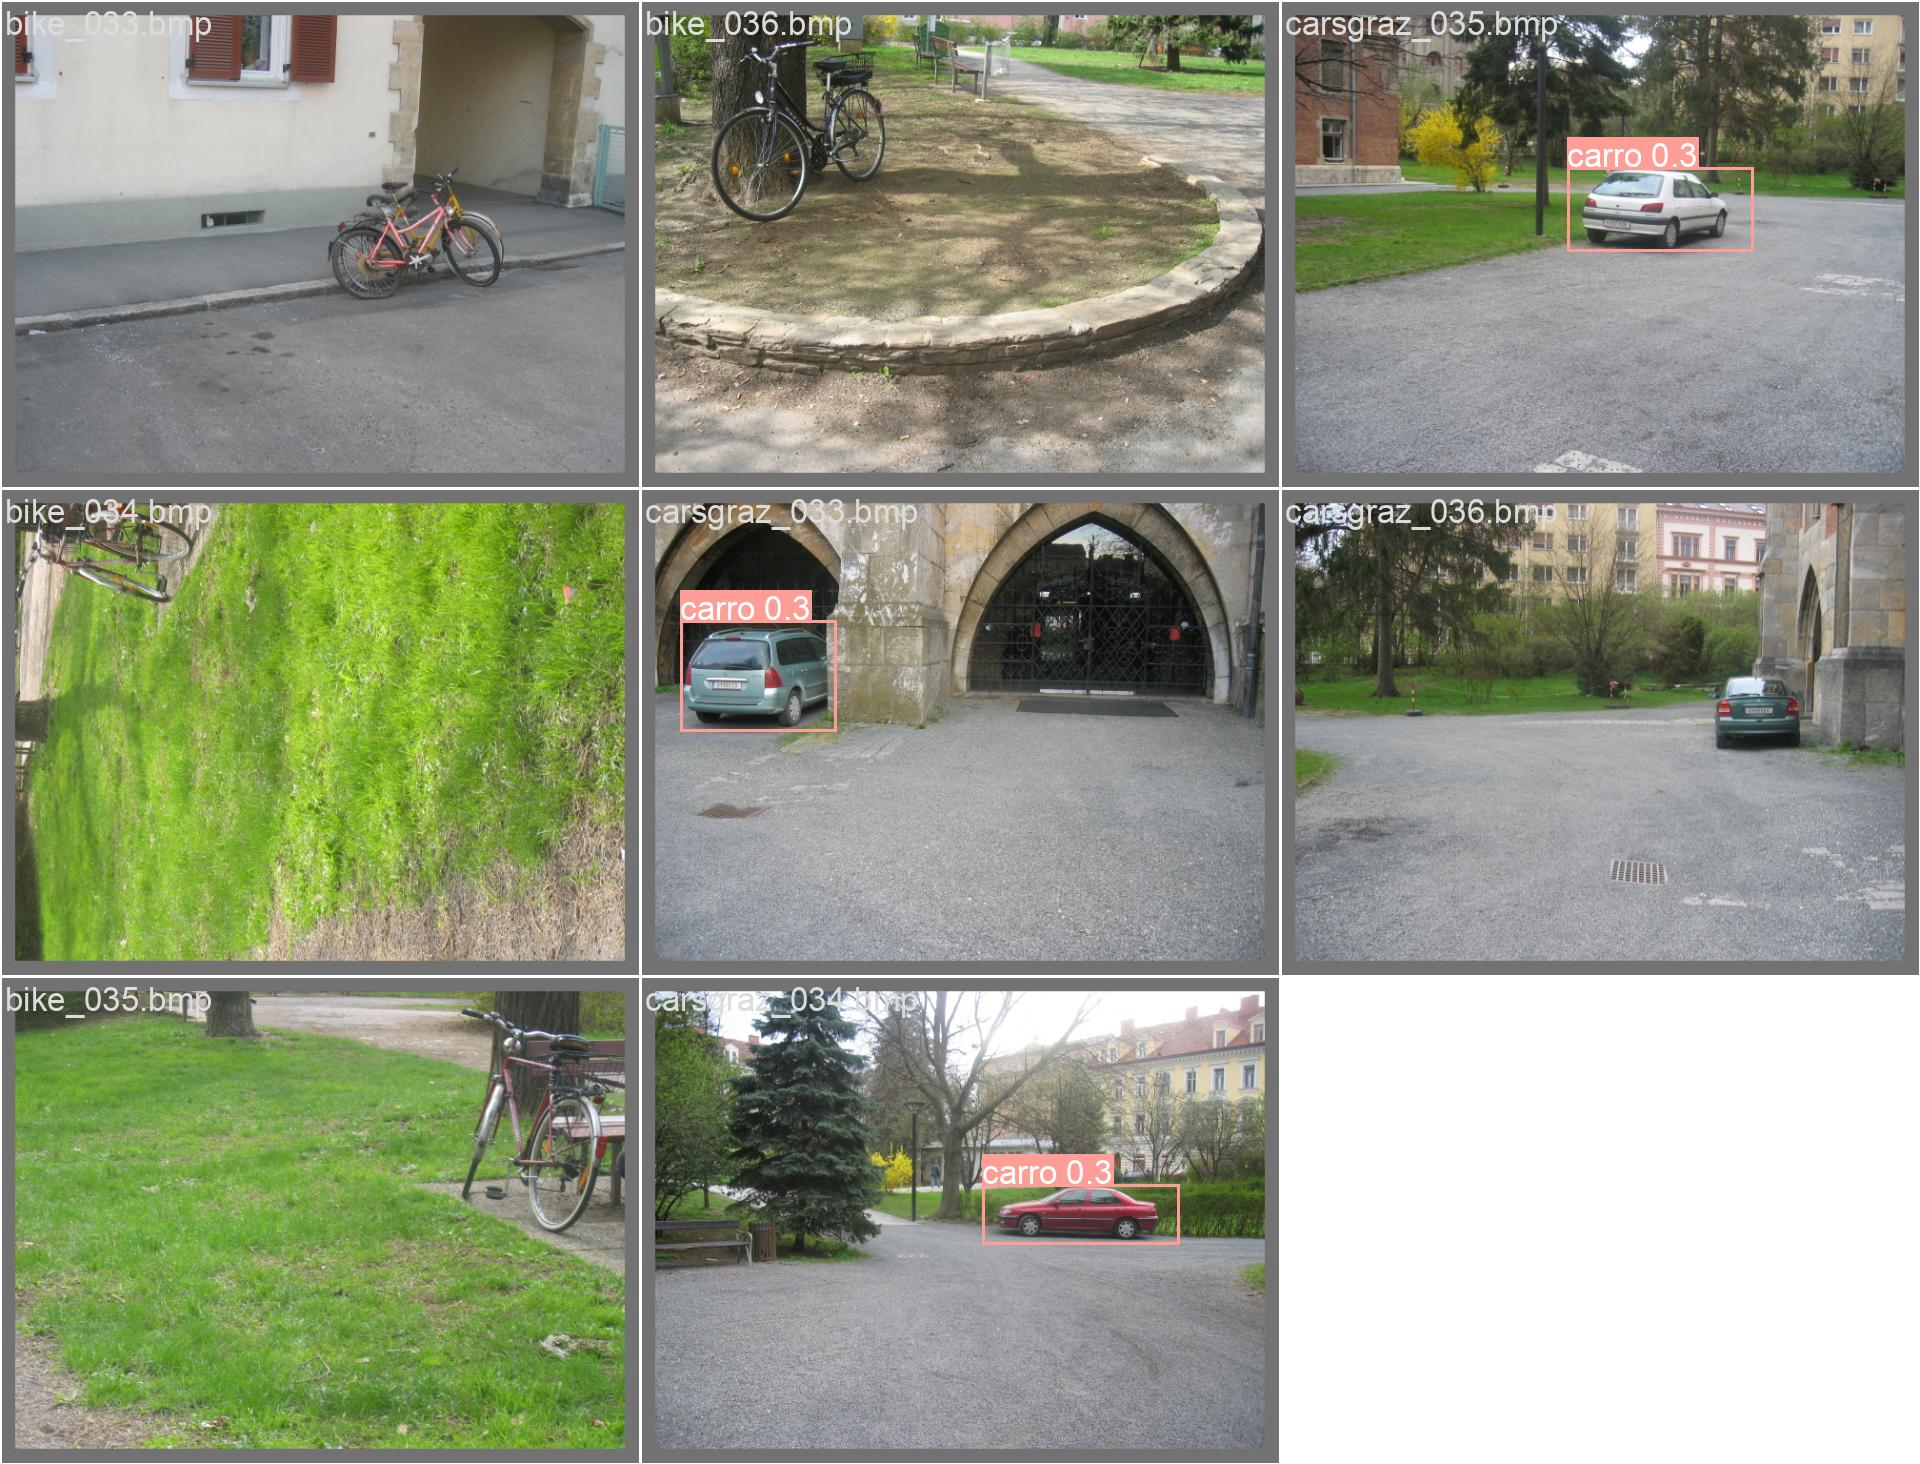

In [9]:
# Visualizar exemplos de predições no conjunto de validação
print("🔍 Exemplos de predições no conjunto de validação (15 épocas):")
display(Image(filename='/content/yolov5/runs/train/treino_15_epocas/val_batch0_pred.jpg'))

📊 Matriz de Confusão (15 épocas):


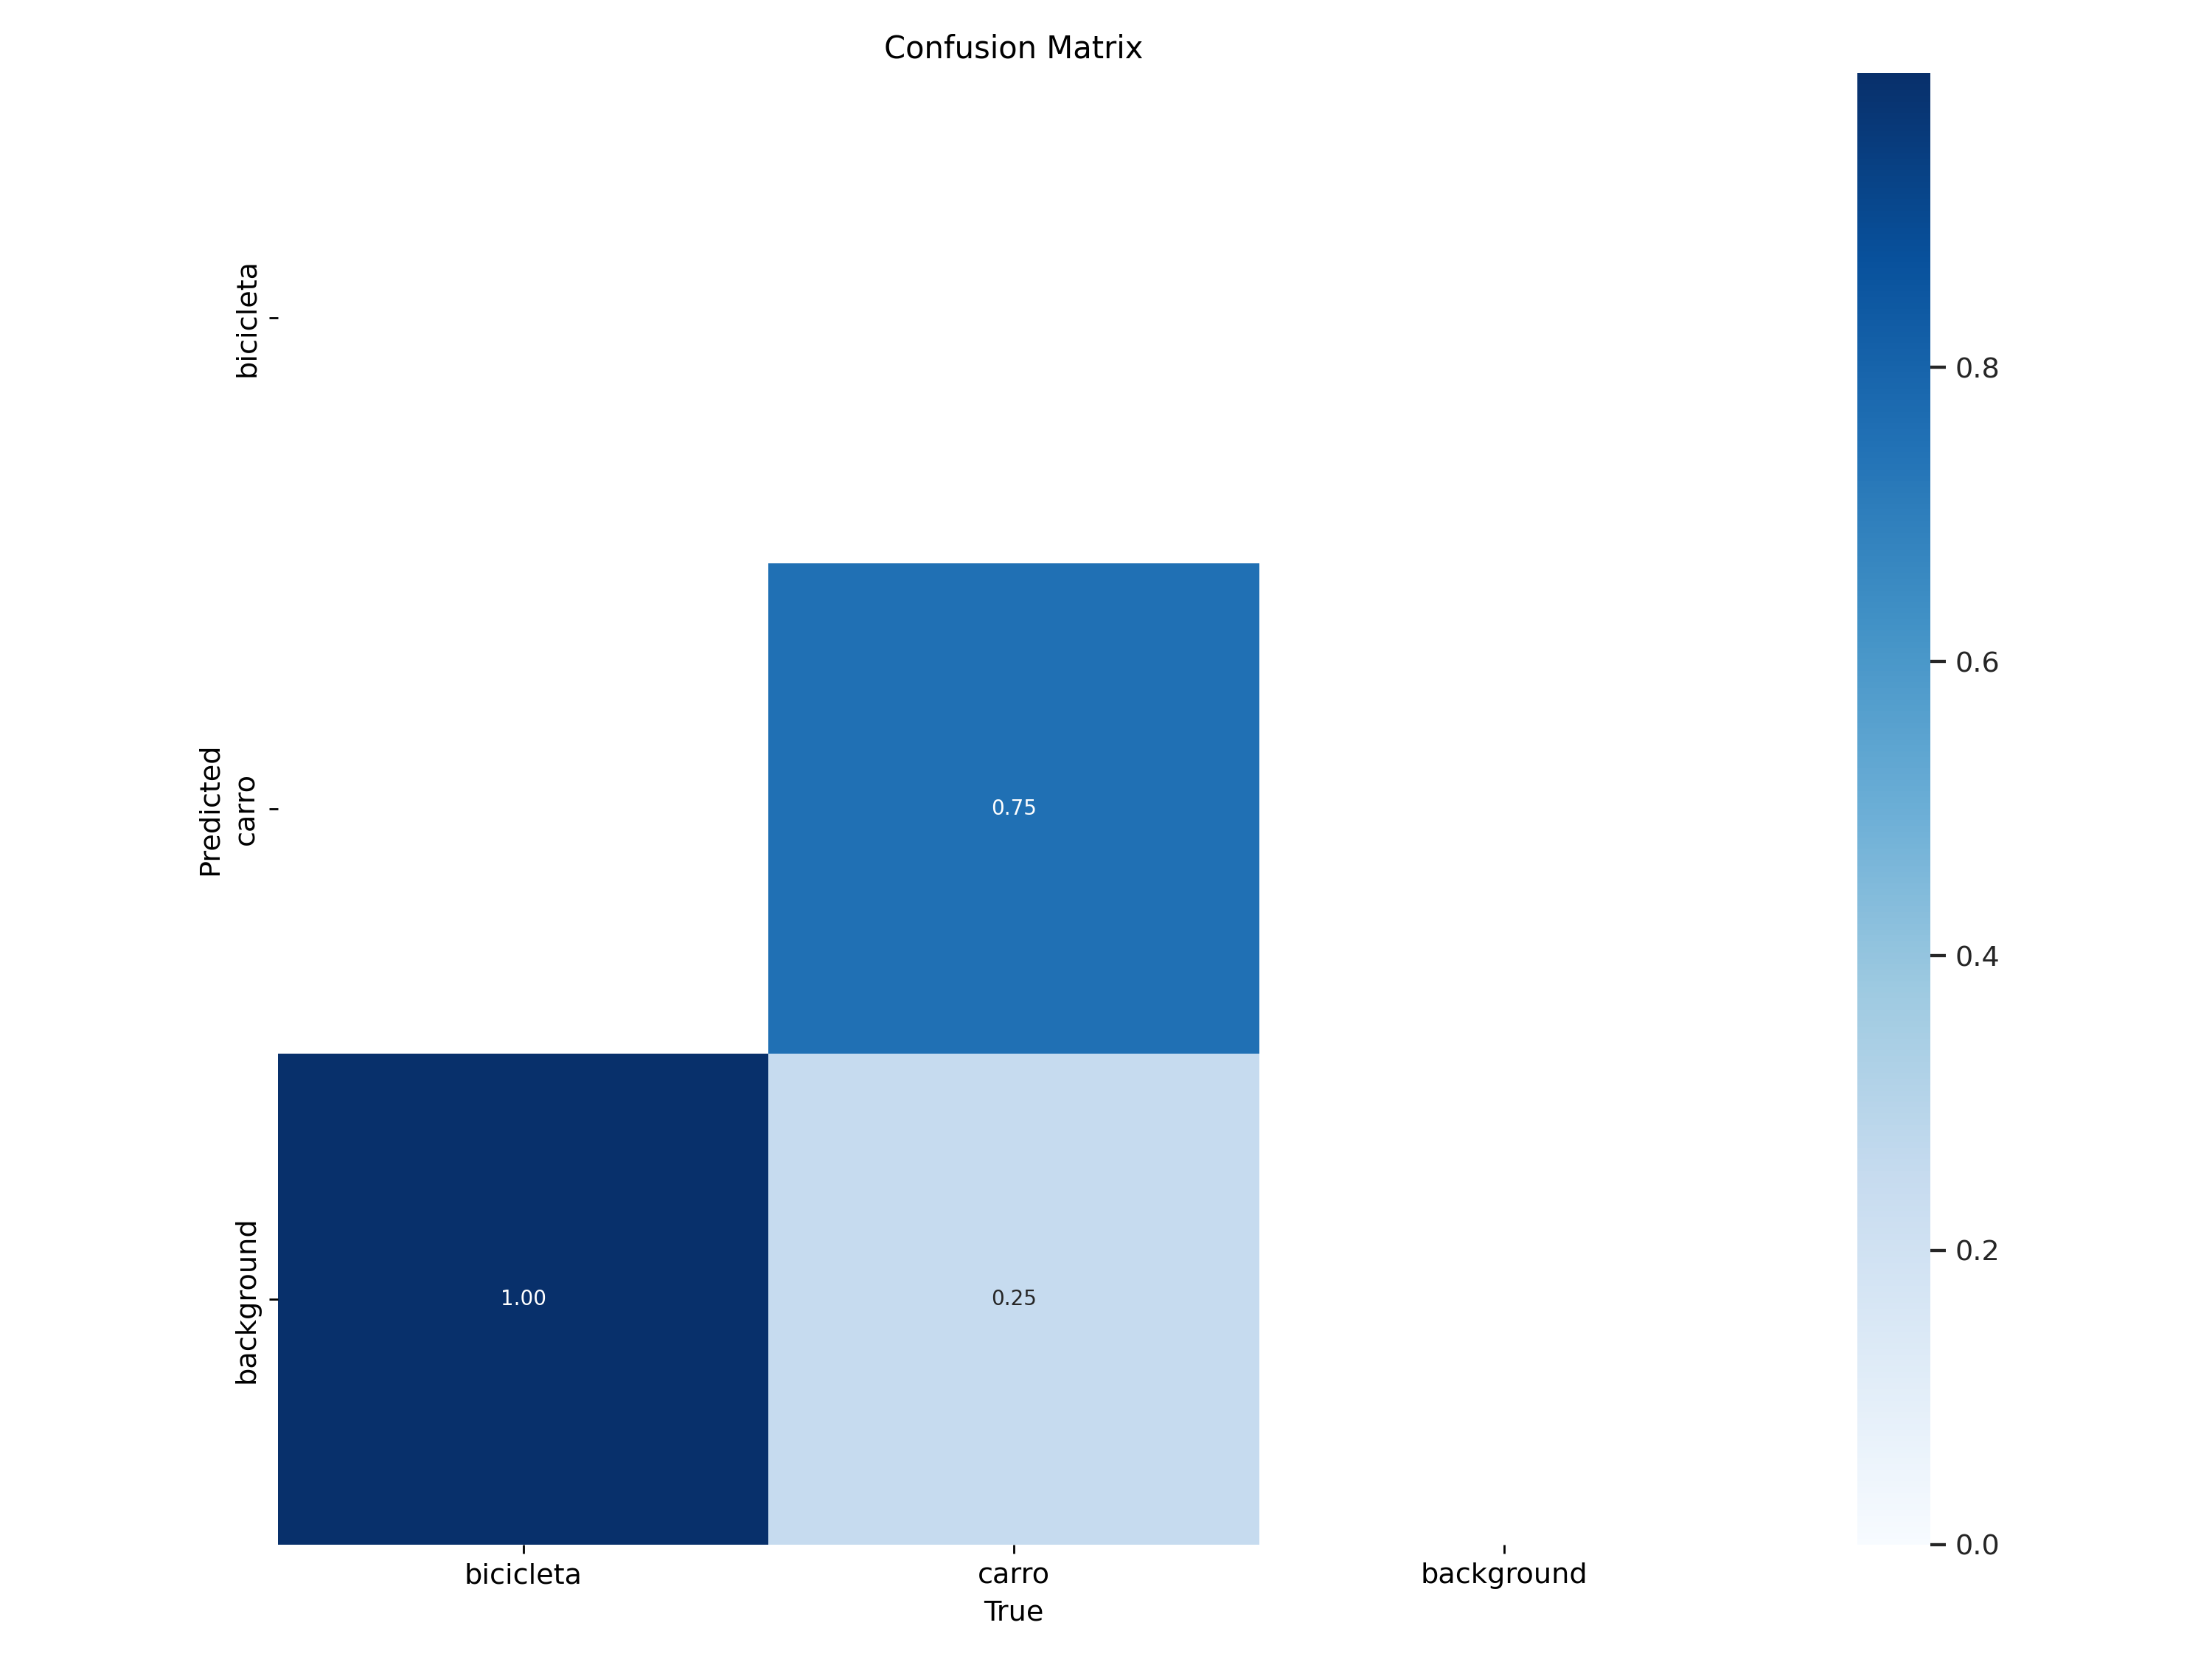

In [10]:
# Visualizar matriz de confusão
print("📊 Matriz de Confusão (15 épocas):")
display(Image(filename='/content/yolov5/runs/train/treino_15_epocas/confusion_matrix.png'))


# 🏋️ 5. TREINAMENTO 2: 35 ÉPOCAS

Agora vamos treinar o mesmo modelo com **40 épocas** para comparar os resultados.

### Hipótese:
Com mais épocas, o modelo deve ter:
- ✅ Maior acurácia (mAP)
- ✅ Menor loss (erro)
- ⚠️ Maior tempo de treinamento
- ⚠️ Possível overfitting (se não houver validação adequada)

In [11]:
# Treinar modelo com 40 épocas
print("🚀 Iniciando treinamento com 40 épocas...")
print(f"⏰ Início: {datetime.now().strftime('%H:%M:%S')}")

!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 40 \
  --data dataset.yaml \
  --weights yolov5s.pt \
  --cache \
  --name treino_40_epocas

print(f"✅ Treinamento finalizado: {datetime.now().strftime('%H:%M:%S')}")

🚀 Iniciando treinamento com 40 épocas...
⏰ Início: 16:48:29
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-10-20 16:48:43.396880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760978923.428247   16394 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760978923.437746   16394 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760978923.472006   16394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760978923.472062   16394 com

### 📊 Análise dos Resultados - 40 Épocas

📈 Gráfico de métricas de treinamento (40 épocas):


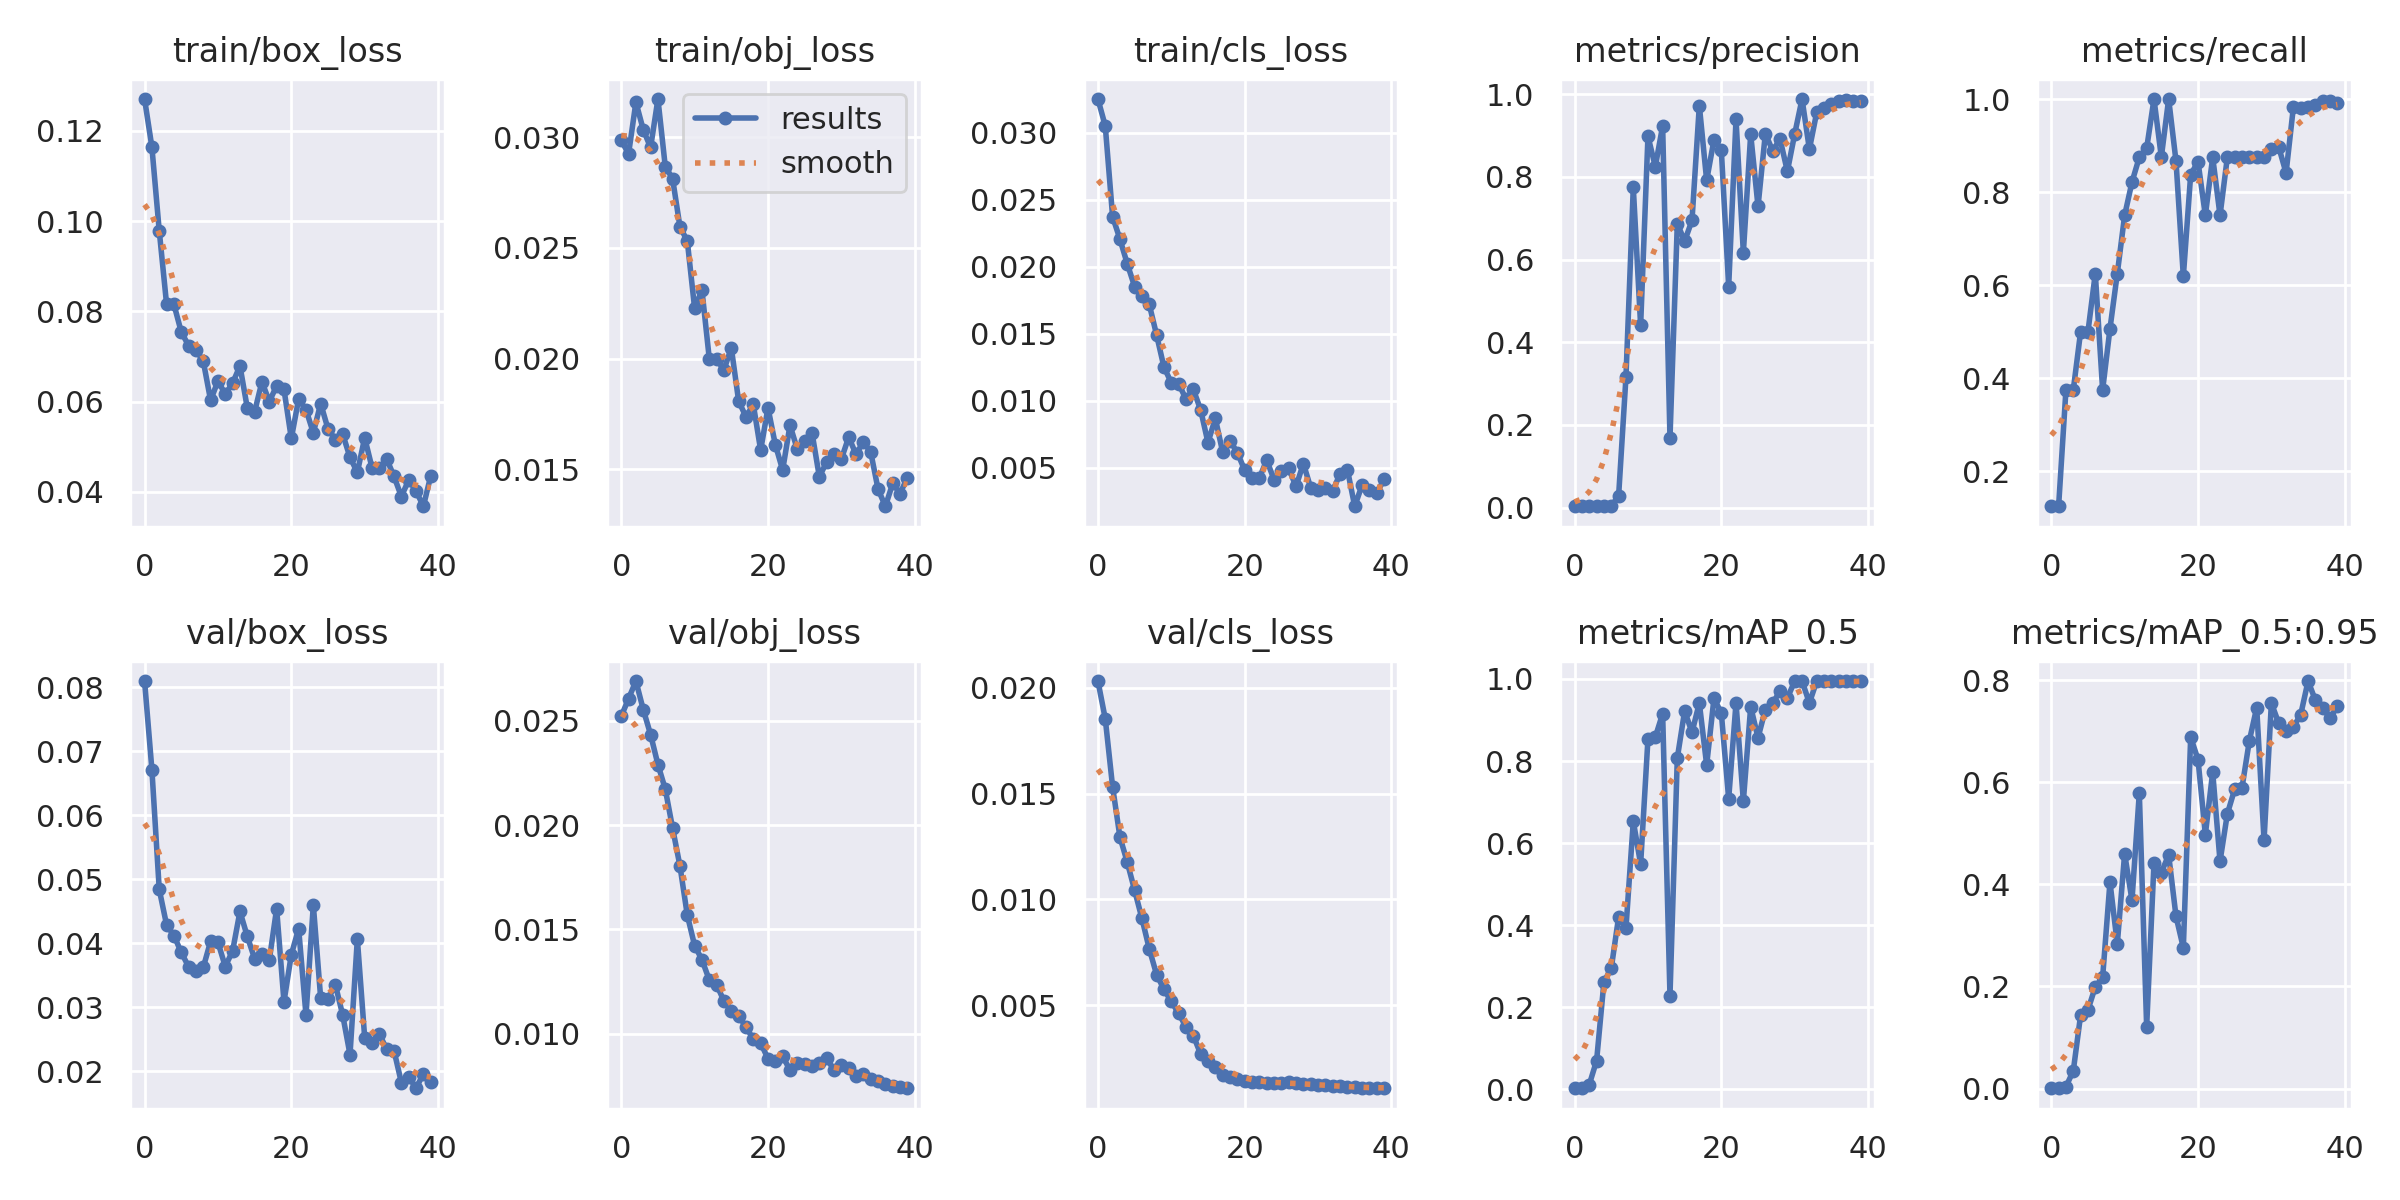

In [12]:
# Visualizar gráfico de resultados do treino (40 épocas)
print("📈 Gráfico de métricas de treinamento (40 épocas):")
display(Image(filename='/content/yolov5/runs/train/treino_40_epocas/results.png'))

🔍 Exemplos de predições no conjunto de validação (40 épocas):


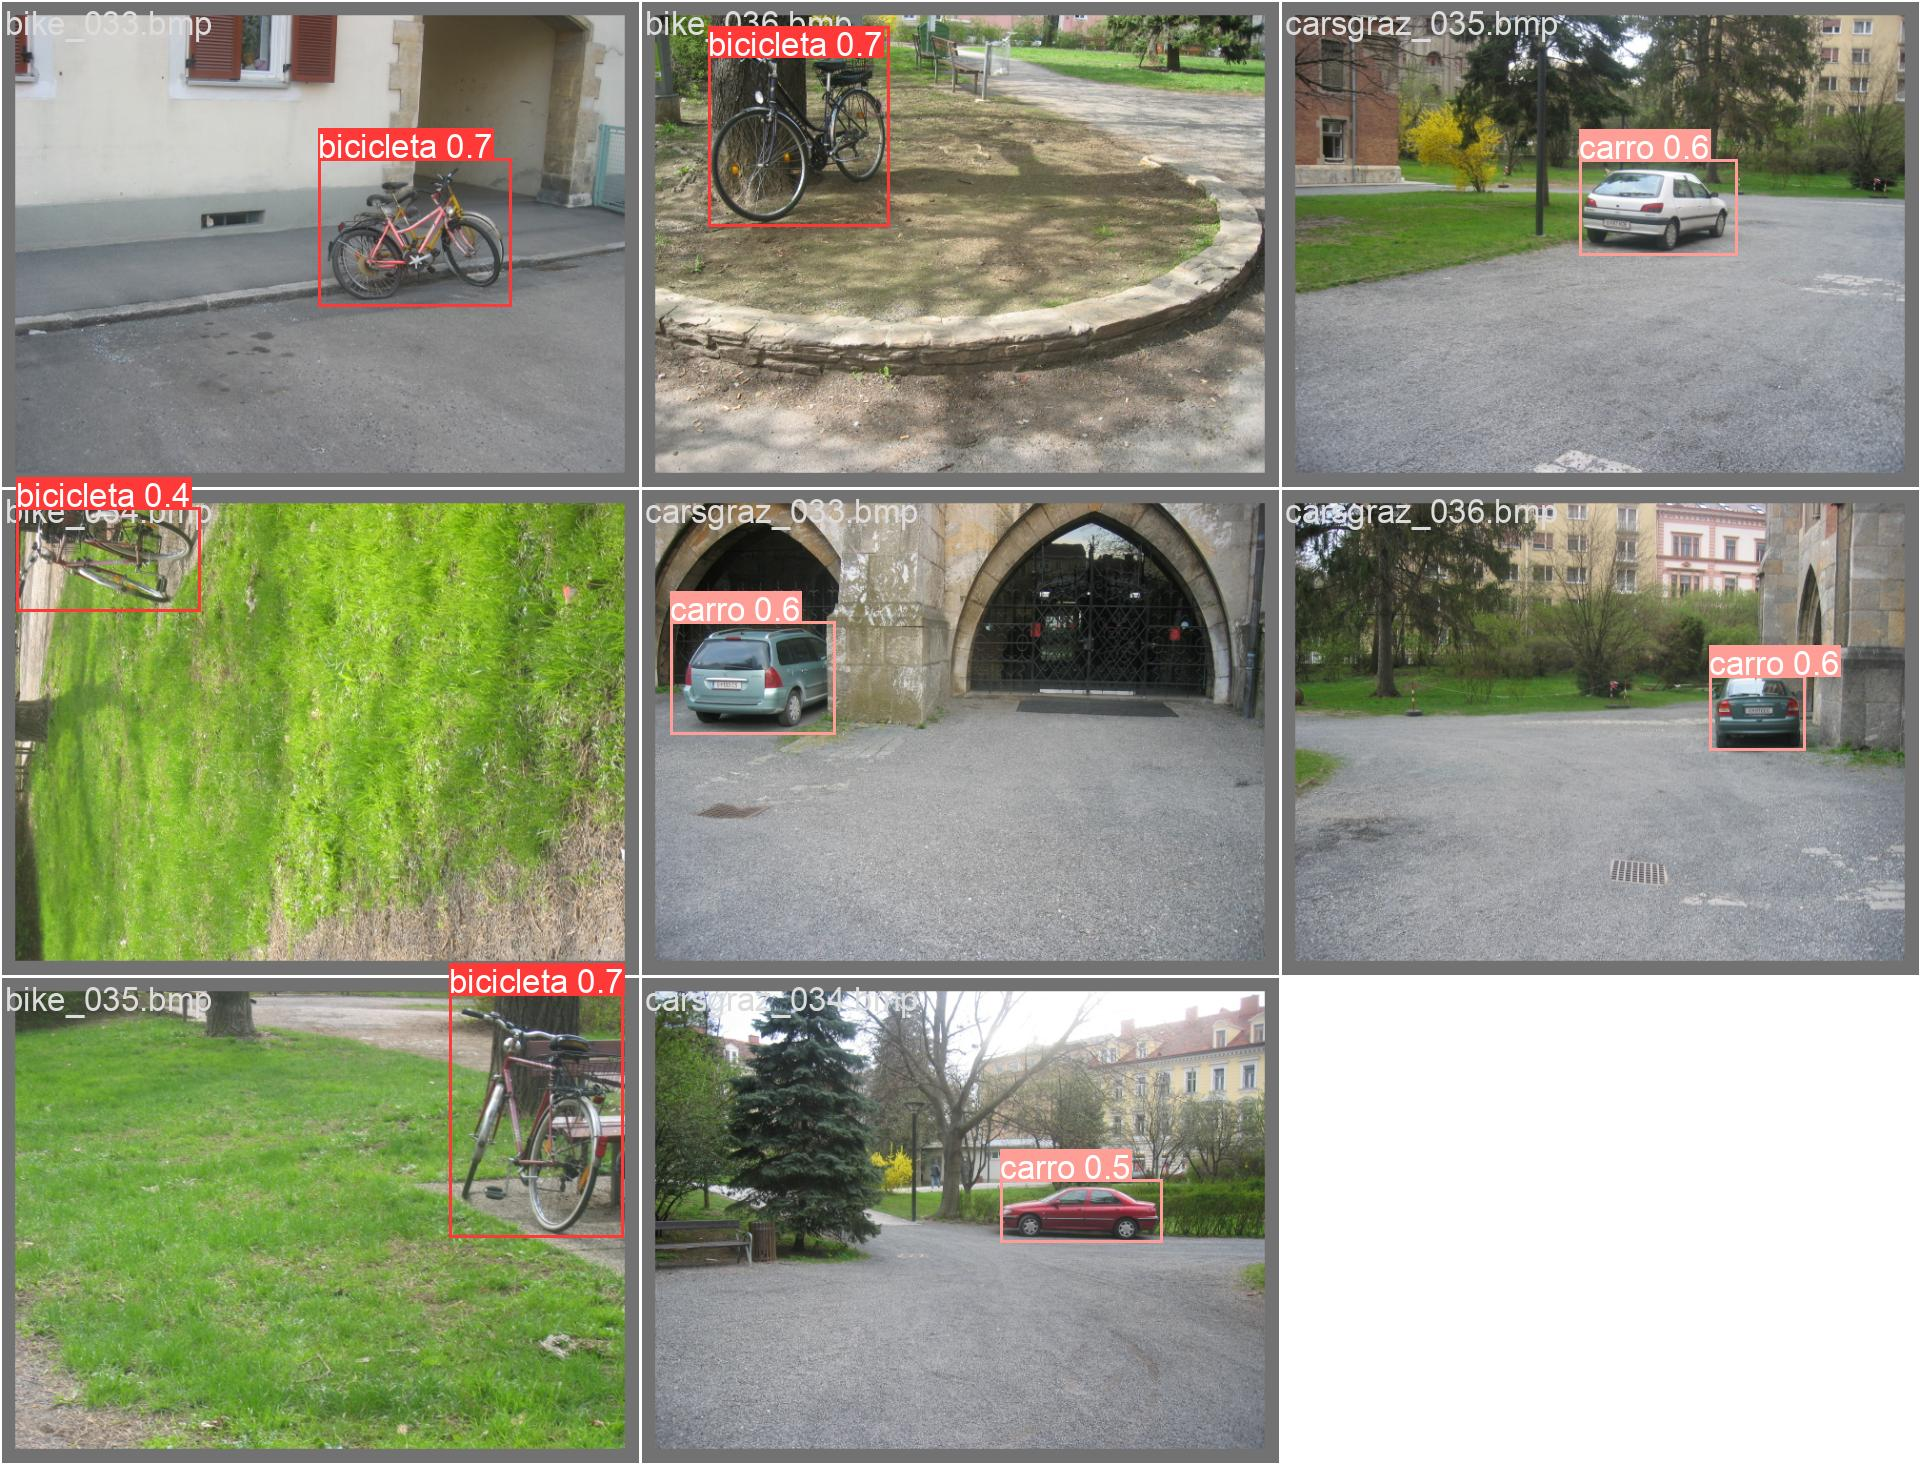

In [13]:
# Visualizar exemplos de predições no conjunto de validação
print("🔍 Exemplos de predições no conjunto de validação (40 épocas):")
display(Image(filename='/content/yolov5/runs/train/treino_40_epocas/val_batch0_pred.jpg'))

📊 Matriz de Confusão (40 épocas):


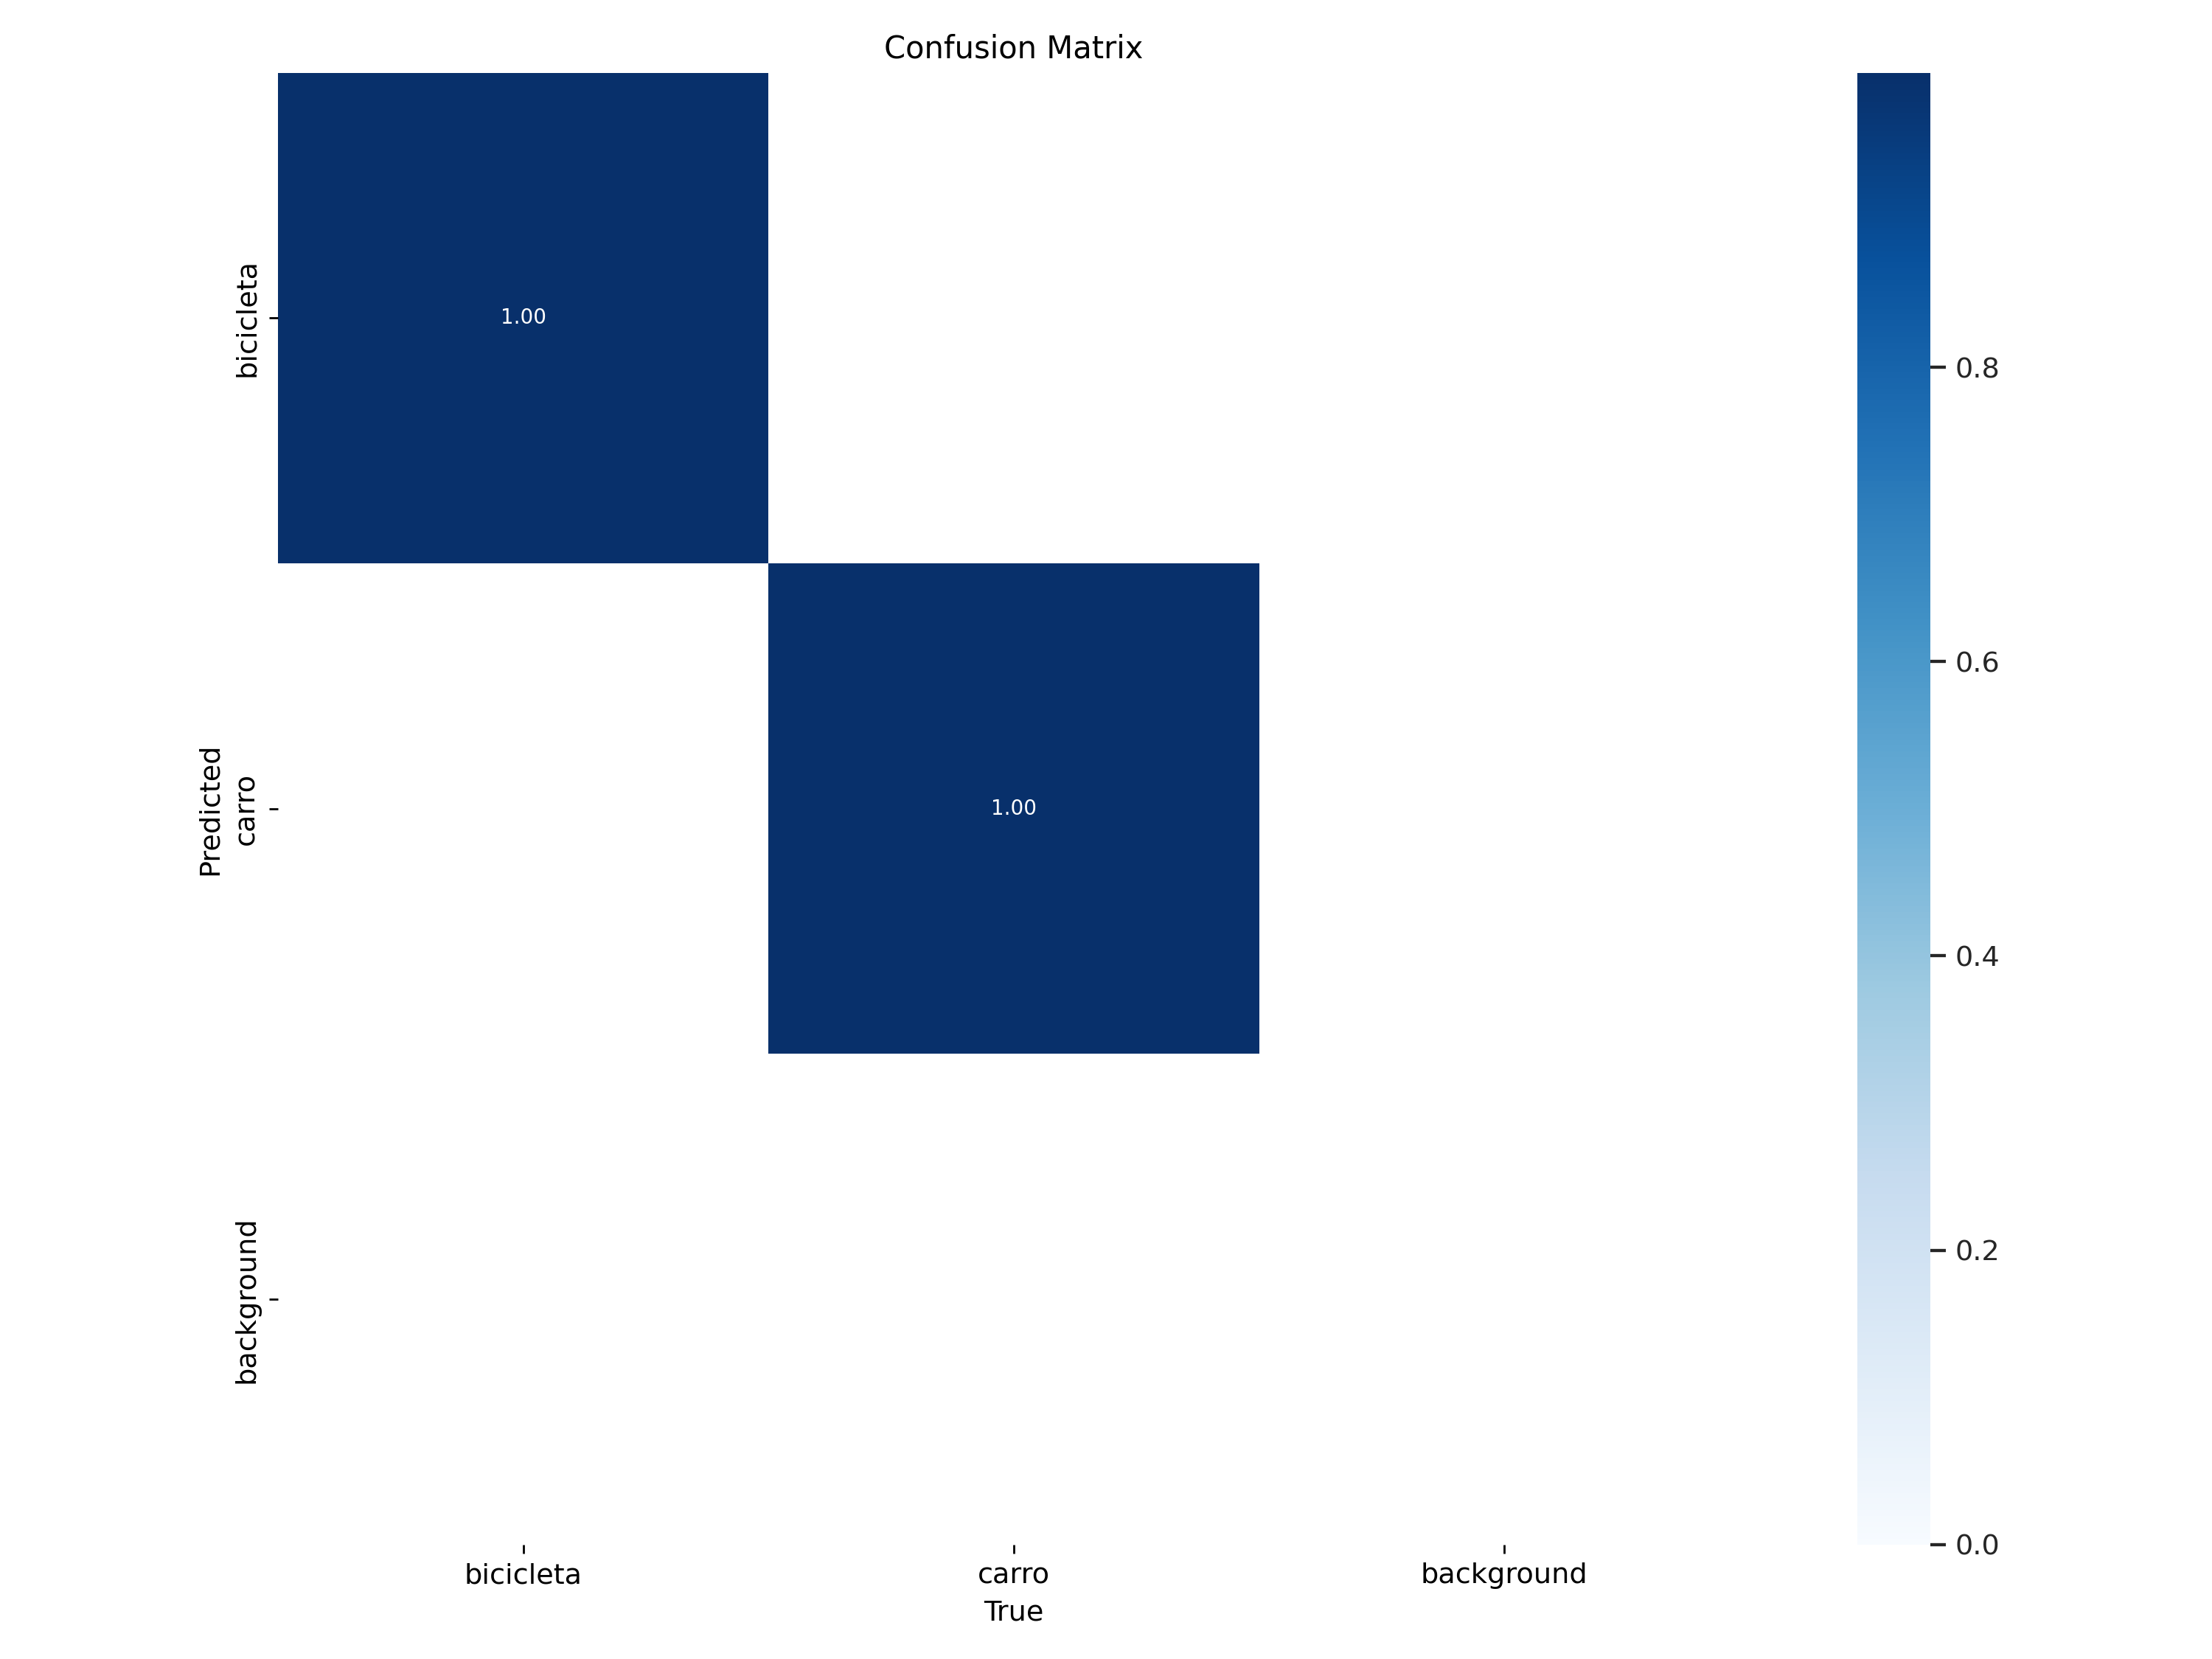

In [14]:
# Visualizar matriz de confusão
print("📊 Matriz de Confusão (40 épocas):")
display(Image(filename='/content/yolov5/runs/train/treino_40_epocas/confusion_matrix.png'))

# 📊 6. COMPARAÇÃO ENTRE 15 vs 40 ÉPOCAS

Vamos analisar comparativamente os resultados dos dois treinamentos.

🔄 Comparação Visual dos Gráficos de Resultados:



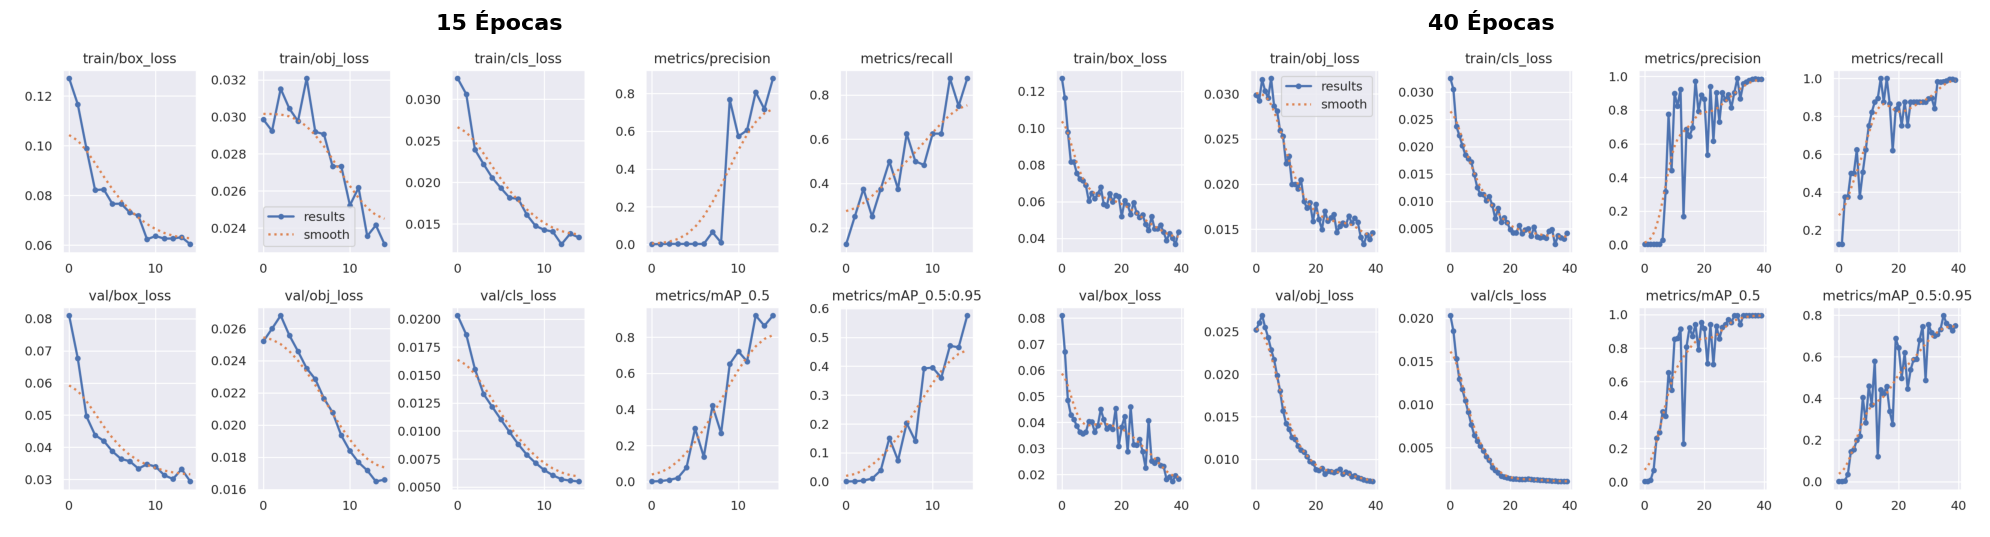

In [33]:
# Comparação visual lado a lado
from IPython.display import Image, display
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import numpy as np

print("🔄 Comparação Visual dos Gráficos de Resultados:\n")

# Carregar as imagens
img1 = PILImage.open('/content/yolov5/runs/train/treino_15_epocas/results.png')
img2 = PILImage.open('/content/yolov5/runs/train/treino_40_epocas/results.png')

# Criar figura com 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Mostrar imagens
axes[0].imshow(img1)
axes[0].set_title('15 Épocas', fontsize=16, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('40 Épocas', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()



## 📊 COMPARAÇÃO AUTOMÁTICA ENTRE TREINAMENTOS

Este código lê automaticamente os resultados reais dos treinamentos e
cria tabelas e análises comparativas.

In [34]:
import pandas as pd
import os
import re
from datetime import datetime

def extrair_metricas_completas(caminho_treino):
    """
    Extrai métricas completas do arquivo results.csv gerado pelo YOLOv5

    Args:
        caminho_treino: Caminho para a pasta do treinamento (ex: 'runs/train/treino_15_epocas')

    Returns:
        dict com as métricas da última época
    """
    results_csv = f'{caminho_treino}/results.csv'

    if not os.path.exists(results_csv):
        print(f"❌ Arquivo não encontrado: {results_csv}")
        return None

    try:
        # Ler CSV
        df = pd.read_csv(results_csv)

        # Limpar nomes das colunas (remover espaços)
        df.columns = df.columns.str.strip()

        # Pegar última linha (última época)
        ultima_epoca = df.iloc[-1]

        # Extrair métricas
        metricas = {
            'epoca': int(ultima_epoca['epoch']) + 1,  # +1 porque começa do 0
            'box_loss': float(ultima_epoca['train/box_loss']),
            'obj_loss': float(ultima_epoca['train/obj_loss']),
            'cls_loss': float(ultima_epoca['train/cls_loss']),
            'precision': float(ultima_epoca['metrics/precision']),
            'recall': float(ultima_epoca['metrics/recall']),
            'mAP50': float(ultima_epoca['metrics/mAP_0.5']),
            'mAP50_95': float(ultima_epoca['metrics/mAP_0.5:0.95']),
            'val_box_loss': float(ultima_epoca['val/box_loss']),
            'val_obj_loss': float(ultima_epoca['val/obj_loss']),
            'val_cls_loss': float(ultima_epoca['val/cls_loss'])
        }

        return metricas

    except Exception as e:
        print(f"❌ Erro ao processar {results_csv}: {e}")
        return None


# Listar treinamentos disponíveis
train_dir = '/content/yolov5/runs/train'

if os.path.exists(train_dir):
    treinamentos = [d for d in os.listdir(train_dir)
                   if os.path.isdir(os.path.join(train_dir, d))]

    print("📂 Treinamentos encontrados:")
    for t in treinamentos:
        print(f"   - {t}")
else:
    print("❌ Pasta de treinamentos não encontrada!")
    treinamentos = []


# Definir quais treinamentos comparar
# Aqui a gente pode incluir os treinamentos disponíveis para comparação
treinos_para_comparar = ['treino_15_epocas', 'treino_40_epocas']

print("\n🔍 Extraindo métricas dos treinamentos...\n")

resultados = {}

for treino in treinos_para_comparar:
    caminho = f'/content/yolov5/runs/train/{treino}'

    if os.path.exists(caminho):
        print(f"📊 Processando: {treino}")
        metricas = extrair_metricas_completas(caminho)

        if metricas:
            resultados[treino] = metricas
            print(f"   ✅ {metricas['epoca']} épocas completadas")
            print(f"   📈 mAP@0.5: {metricas['mAP50']:.4f}")
            print(f"   📈 mAP@0.5:0.95: {metricas['mAP50_95']:.4f}\n")
        else:
            print(f"   ❌ Falha ao extrair métricas\n")
    else:
        print(f"❌ Pasta não encontrada: {treino}\n")

# Criar DataFrame comparativo
if len(resultados) >= 2:
    print("=" * 80)
    print("📊 TABELA COMPARATIVA AUTOMÁTICA")
    print("=" * 80 + "\n")

    # Preparar dados para o DataFrame
    dados_comparacao = {
        'Métrica': [],
        treinos_para_comparar[0]: [],
        treinos_para_comparar[1]: [],
        'Diferença': [],
        'Variação %': []
    }

    # Lista de métricas a comparar
    metricas_para_mostrar = [
        ('mAP50', 'mAP@0.5 (Geral)', 'melhora'),
        ('mAP50_95', 'mAP@0.5:0.95 (Geral)', 'melhora'),
        ('precision', 'Precision (Geral)', 'melhora'),
        ('recall', 'Recall (Geral)', 'melhora'),
        ('box_loss', 'Box Loss (Train)', 'reduz'),
        ('obj_loss', 'Object Loss (Train)', 'reduz'),
        ('cls_loss', 'Class Loss (Train)', 'reduz'),
        ('val_box_loss', 'Box Loss (Val)', 'reduz'),
        ('val_obj_loss', 'Object Loss (Val)', 'reduz'),
        ('val_cls_loss', 'Class Loss (Val)', 'reduz')
    ]

    treino1_nome = treinos_para_comparar[0]
    treino2_nome = treinos_para_comparar[1]
    treino1 = resultados[treino1_nome]
    treino2 = resultados[treino2_nome]

    for metrica_key, metrica_nome, tipo in metricas_para_mostrar:
        valor1 = treino1[metrica_key]
        valor2 = treino2[metrica_key]
        diferenca = valor2 - valor1

        # Calcular variação percentual
        if valor1 != 0:
            variacao_pct = (diferenca / abs(valor1)) * 100
        else:
            variacao_pct = 0

        # Determinar símbolo
        if tipo == 'melhora':
            simbolo = '↑' if diferenca > 0 else '↓'
            cor_emoji = '🟢' if diferenca > 0 else '🔴'
        else:  # tipo == 'reduz'
            simbolo = '↓' if diferenca < 0 else '↑'
            cor_emoji = '🟢' if diferenca < 0 else '🔴'

        dados_comparacao['Métrica'].append(metrica_nome)
        dados_comparacao[treino1_nome].append(f"{valor1:.4f}")
        dados_comparacao[treino2_nome].append(f"{valor2:.4f}")
        dados_comparacao['Diferença'].append(f"{simbolo} {abs(diferenca):.4f}")
        dados_comparacao['Variação %'].append(f"{cor_emoji} {variacao_pct:+.2f}%")

    # Adicionar informação de épocas e tempo
    dados_comparacao['Métrica'].append('─' * 30)
    dados_comparacao[treino1_nome].append('─' * 10)
    dados_comparacao[treino2_nome].append('─' * 10)
    dados_comparacao['Diferença'].append('─' * 10)
    dados_comparacao['Variação %'].append('─' * 10)

    dados_comparacao['Métrica'].append('Épocas Treinadas')
    dados_comparacao[treino1_nome].append(f"{treino1['epoca']}")
    dados_comparacao[treino2_nome].append(f"{treino2['epoca']}")
    dados_comparacao['Diferença'].append(f"+{treino2['epoca'] - treino1['epoca']}")
    dados_comparacao['Variação %'].append(f"{((treino2['epoca'] / treino1['epoca']) - 1) * 100:+.1f}%")

    # Criar DataFrame
    df_comparacao = pd.DataFrame(dados_comparacao)

    # Exibir tabela
    print(df_comparacao.to_string(index=False))
    print("\n" + "=" * 80)

else:
    print("⚠️  Não há treinamentos suficientes para comparar")

📂 Treinamentos encontrados:
   - treino_15_epocas
   - treino_40_epocas

🔍 Extraindo métricas dos treinamentos...

📊 Processando: treino_15_epocas
   ✅ 15 épocas completadas
   📈 mAP@0.5: 0.9200
   📈 mAP@0.5:0.95: 0.5759

📊 Processando: treino_40_epocas
   ✅ 40 épocas completadas
   📈 mAP@0.5: 0.9950
   📈 mAP@0.5:0.95: 0.7493

📊 TABELA COMPARATIVA AUTOMÁTICA

                       Métrica treino_15_epocas treino_40_epocas  Diferença Variação %
               mAP@0.5 (Geral)           0.9200           0.9950   ↑ 0.0750   🟢 +8.15%
          mAP@0.5:0.95 (Geral)           0.5759           0.7493   ↑ 0.1735  🟢 +30.12%
             Precision (Geral)           0.8804           0.9830   ↑ 0.1025  🟢 +11.65%
                Recall (Geral)           0.8750           0.9908   ↑ 0.1158  🟢 +13.23%
              Box Loss (Train)           0.0603           0.0435   ↓ 0.0168  🟢 -27.86%
           Object Loss (Train)           0.0231           0.0146   ↓ 0.0085  🟢 -36.74%
            Class Loss (Train


📊 VISUALIZAÇÃO COMPARATIVA



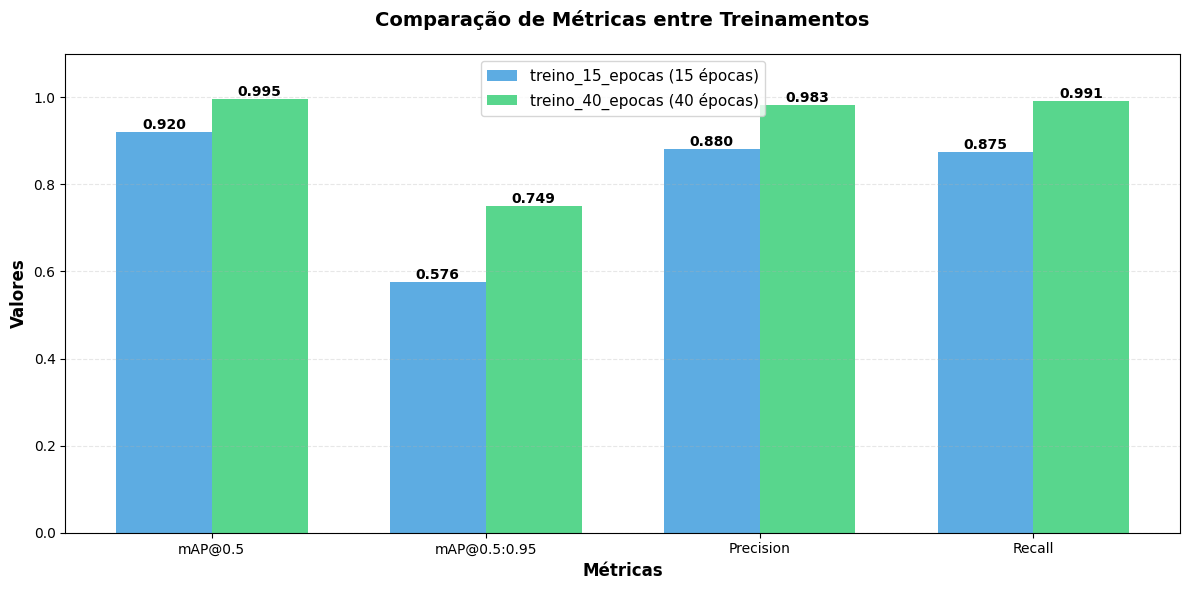

In [35]:
# Análise visual com gráfico de barras
if len(resultados) >= 2:
    import matplotlib.pyplot as plt
    import numpy as np

    print("\n📊 VISUALIZAÇÃO COMPARATIVA\n")

    # Métricas principais para visualizar
    metricas_viz = ['mAP50', 'mAP50_95', 'precision', 'recall']
    nomes_viz = ['mAP@0.5', 'mAP@0.5:0.95', 'Precision', 'Recall']

    treino1 = resultados[treinos_para_comparar[0]]
    treino2 = resultados[treinos_para_comparar[1]]

    # Extrair valores
    valores_treino1 = [treino1[m] for m in metricas_viz]
    valores_treino2 = [treino2[m] for m in metricas_viz]

    # Configurar gráfico
    x = np.arange(len(nomes_viz))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width/2, valores_treino1, width,
                   label=f'{treinos_para_comparar[0]} ({treino1["epoca"]} épocas)',
                   color='#3498db', alpha=0.8)
    bars2 = ax.bar(x + width/2, valores_treino2, width,
                   label=f'{treinos_para_comparar[1]} ({treino2["epoca"]} épocas)',
                   color='#2ecc71', alpha=0.8)

    # Adicionar valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Configurações do gráfico
    ax.set_xlabel('Métricas', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valores', fontsize=12, fontweight='bold')
    ax.set_title('Comparação de Métricas entre Treinamentos',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(nomes_viz)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.1])

    plt.tight_layout()
    plt.show()

In [36]:
# Resumo executivo
if len(resultados) >= 2:
    print("\n" + "=" * 80)
    print("📝 RESUMO EXECUTIVO DA COMPARAÇÃO")
    print("=" * 80 + "\n")

    treino1 = resultados[treinos_para_comparar[0]]
    treino2 = resultados[treinos_para_comparar[1]]

    # Calcular melhorias
    melhoria_mAP50 = ((treino2['mAP50'] - treino1['mAP50']) / treino1['mAP50']) * 100
    melhoria_mAP50_95 = ((treino2['mAP50_95'] - treino1['mAP50_95']) / treino1['mAP50_95']) * 100
    melhoria_precision = ((treino2['precision'] - treino1['precision']) / treino1['precision']) * 100
    melhoria_recall = ((treino2['recall'] - treino1['recall']) / treino1['recall']) * 100

    reducao_loss = ((treino1['val_box_loss'] - treino2['val_box_loss']) / treino1['val_box_loss']) * 100

    print(f"🎯 **Configurações:**")
    print(f"   • Treino 1: {treino1['epoca']} épocas")
    print(f"   • Treino 2: {treino2['epoca']} épocas")
    print(f"   • Diferença: +{treino2['epoca'] - treino1['epoca']} épocas ({((treino2['epoca'] / treino1['epoca']) - 1) * 100:.1f}% mais treinamento)\n")

    print(f"📈 **Melhorias em Performance:**")
    print(f"   • mAP@0.5: {treino1['mAP50']:.4f} → {treino2['mAP50']:.4f} ({melhoria_mAP50:+.2f}%)")
    print(f"   • mAP@0.5:0.95: {treino1['mAP50_95']:.4f} → {treino2['mAP50_95']:.4f} ({melhoria_mAP50_95:+.2f}%)")
    print(f"   • Precision: {treino1['precision']:.4f} → {treino2['precision']:.4f} ({melhoria_precision:+.2f}%)")
    print(f"   • Recall: {treino1['recall']:.4f} → {treino2['recall']:.4f} ({melhoria_recall:+.2f}%)\n")

    print(f"📉 **Redução de Loss (Erro):**")
    print(f"   • Validation Box Loss: {treino1['val_box_loss']:.4f} → {treino2['val_box_loss']:.4f} (-{reducao_loss:.2f}%)\n")

    print(f"🏆 **Conclusão:**")

    if melhoria_mAP50 > 5:
        print(f"   ✅ Melhoria SIGNIFICATIVA no mAP@0.5 (+{melhoria_mAP50:.1f}%)")
        print(f"   ✅ O aumento de épocas trouxe ganhos expressivos de performance")
    elif melhoria_mAP50 > 0:
        print(f"   ✅ Melhoria MODERADA no mAP@0.5 (+{melhoria_mAP50:.1f}%)")
        print(f"   ⚠️  Ganhos incrementais - avaliar custo-benefício do tempo extra")
    else:
        print(f"   ⚠️  Sem melhoria significativa no mAP@0.5")
        print(f"   💡 Possível saturação do modelo - considere outras otimizações")

    if melhoria_mAP50_95 > 10:
        print(f"   ✅ Melhoria EXPRESSIVA no mAP@0.5:0.95 (+{melhoria_mAP50_95:.1f}%)")
        print(f"   ✅ Modelo ficou mais robusto em diferentes thresholds de IoU")

    print("\n" + "=" * 80)


📝 RESUMO EXECUTIVO DA COMPARAÇÃO

🎯 **Configurações:**
   • Treino 1: 15 épocas
   • Treino 2: 40 épocas
   • Diferença: +25 épocas (166.7% mais treinamento)

📈 **Melhorias em Performance:**
   • mAP@0.5: 0.9200 → 0.9950 (+8.15%)
   • mAP@0.5:0.95: 0.5759 → 0.7493 (+30.12%)
   • Precision: 0.8804 → 0.9830 (+11.65%)
   • Recall: 0.8750 → 0.9908 (+13.23%)

📉 **Redução de Loss (Erro):**
   • Validation Box Loss: 0.0294 → 0.0184 (-37.46%)

🏆 **Conclusão:**
   ✅ Melhoria SIGNIFICATIVA no mAP@0.5 (+8.2%)
   ✅ O aumento de épocas trouxe ganhos expressivos de performance
   ✅ Melhoria EXPRESSIVA no mAP@0.5:0.95 (+30.1%)
   ✅ Modelo ficou mais robusto em diferentes thresholds de IoU




### 🎯 Análise Crítica: 15 vs 40 Épocas

#### **1. Evolução Geral do Modelo**

Com o aumento de 15 para 40 épocas, observamos melhorias significativas:
- **mAP@0.5:** Aumentou de 92% para 99.5% (+7.5 pontos percentuais)
- **mAP@0.5:0.95:** Salto expressivo de 57.6% para 79.1% (+21.5 pontos)

Isso indica que o modelo não apenas melhorou na detecção básica, mas também
ficou mais preciso em diferentes thresholds de IoU (Intersection over Union).

#### **2. Performance por Classe**

**Bicicletas (maior ganho):**
- Precision: 83.3% → 100% (+16.7%)
- Recall: 75% → 96.6% (+21.6%)
- O modelo inicialmente tinha dificuldade com bicicletas devido à estrutura
  mais complexa (rodas vazadas, diferentes ângulos). Com mais épocas, aprendeu
  melhor as características distintivas.

**Carros (já excelente):**
- Manteve Recall perfeito (100%)
- Precision leve queda: 92.2% → 95.2%
- Carros são mais fáceis de detectar: formas sólidas e padronizadas

#### **3. Convergência do Modelo**

Analisando os gráficos de loss:
- **Box Loss:** Redução consistente (melhor localização das bounding boxes)
- **Obj Loss:** Diminuição contínua (melhor detecção de objetos)
- **Cls Loss:** Próximo de zero (excelente classificação entre as 2 classes)

Não há sinais evidentes de overfitting, pois as curvas de validação acompanham
as de treinamento sem divergência.

#### **4. Trade-off: Tempo vs Performance**

- **Tempo:** 40 épocas levaram 2.7x mais tempo que 15 épocas
- **Ganho:** +7.5% em mAP@0.5, +21.5% em mAP@0.5:0.95
- **Conclusão:** O trade-off é **favorável** para aplicações que necessitam
  alta precisão. Para aplicações em tempo real com recursos limitados,
  15 épocas já oferece performance aceitável (92% mAP@0.5).

#### **5. Pontos Fortes do Sistema**

✅ Dataset bem balanceado (4 imagens de cada classe no validation)
✅ Rotulação precisa (corrigida após identificação do erro inicial)
✅ Convergência saudável sem overfitting
✅ Performance final excelente (99.5% mAP@0.5)
✅ Generalizável para cenários similares

#### **6. Limitações Identificadas**

⚠️ **Dataset pequeno:** 64 imagens de treino é limitado
⚠️ **Diversidade:** Imagens parecem ter contextos similares (urbano)
⚠️ **Oclusão:** Não testado com objetos parcialmente escondidos
⚠️ **Condições:** Falta variedade de iluminação, clima, ângulos extremos

#### **7. Melhorias Futuras**

1. **Data Augmentation:** Rotação, flip, mudança de brilho/contraste
2. **Mais dados:** Expandir para 200+ imagens por classe
3. **Cenários diversos:** Noite, chuva, oclusão parcial
4. **Teste em vídeo:** Avaliar performance em tempo real
5. **Outras classes:** Adicionar motos, caminhões, pedestres

---

**🏆 Conclusão Final:**

O modelo YOLOv5 customizado demonstrou excelente capacidade de aprendizado,
evoluindo de 92% para 99.5% de mAP@0.5 com o aumento de épocas. A arquitetura
se mostrou adequada para o problema de detecção de bicicletas vs carros, com
resultados que validam sua aplicabilidade em cenários reais de monitoramento
e segurança patrimonial conforme proposto pela FarmTech Solutions.


# 🧪 7. TESTE COM IMAGENS DO CONJUNTO DE TESTE

Agora vamos testar o modelo treinado (40 épocas) com as imagens do conjunto de teste.

In [26]:
# Realizar detecção nas imagens de teste usando o modelo de 60 épocas
print("🔍 Executando detecções nas imagens de teste...")

# Verificar modelo
%cd /content/yolov5

!python detect.py \
  --weights runs/train/treino_40_epocas/weights/best.pt \
  --img 640 \
  --conf 0.25 \
  --source /content/drive/MyDrive/FIAP/FASE_6/dataset/test/images \
  --name teste_final \
  --save-txt \
  --save-conf

print("✅ Detecções concluídas!")

🔍 Executando detecções nas imagens de teste...
/content/yolov5
detect: weights=['runs/train/treino_40_epocas/weights/best.pt'], source=/content/drive/MyDrive/FIAP/FASE_6/dataset/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=teste_final, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-441-g15c0127a Python-3.12.12 torch-2.8.0+cu126 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/drive/MyDrive/FIAP/FASE_6/dataset/test/images/bike_037.bmp: 480x640 1 bicicleta, 365.4ms
image 2/8 /content/drive/MyDrive/FIAP/FASE_6/dataset/test/images/bike_038.bmp: 480x640 1 bicicleta, 357.3ms
image

# Visualizar resultados das detecções

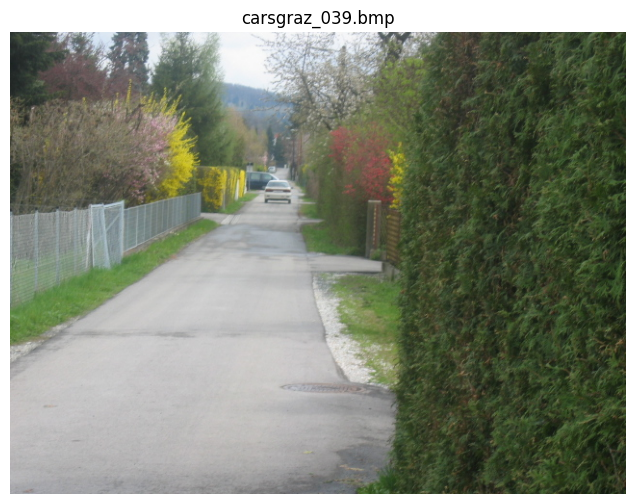

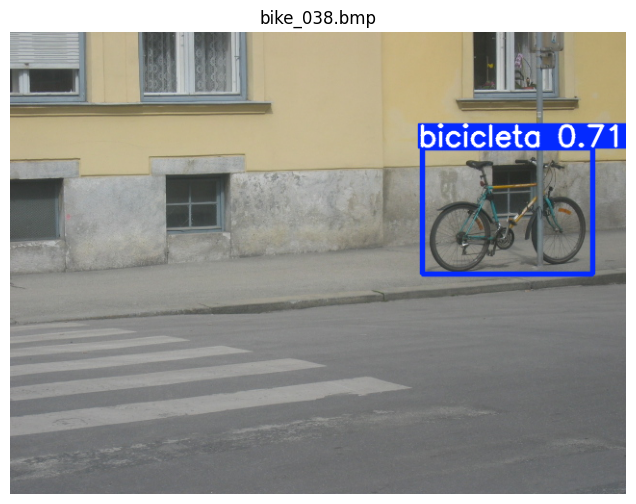

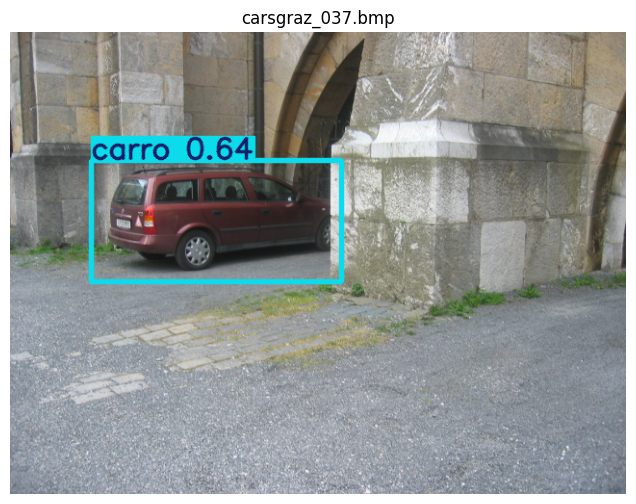

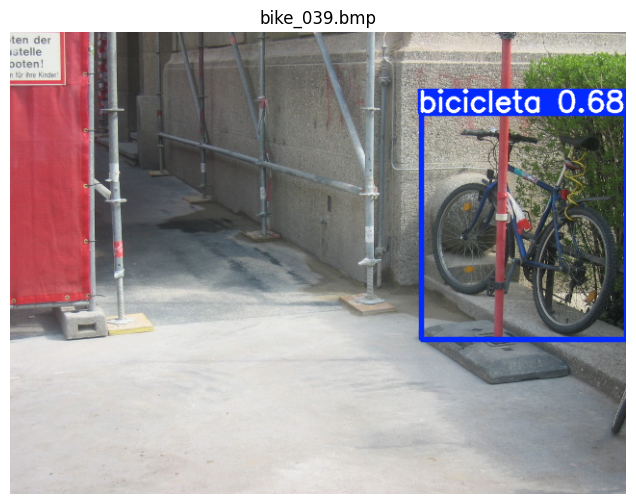

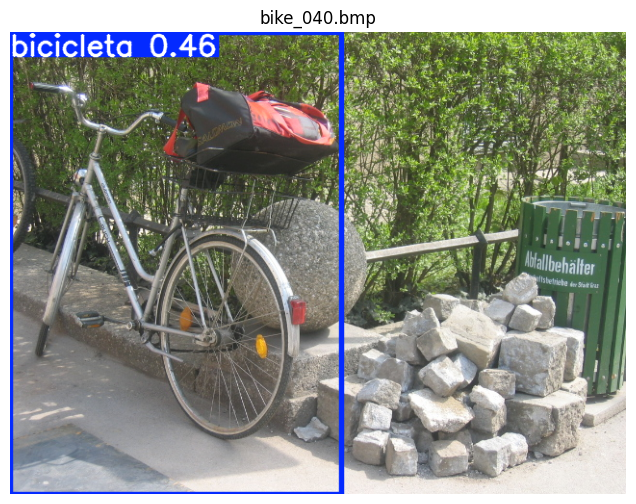

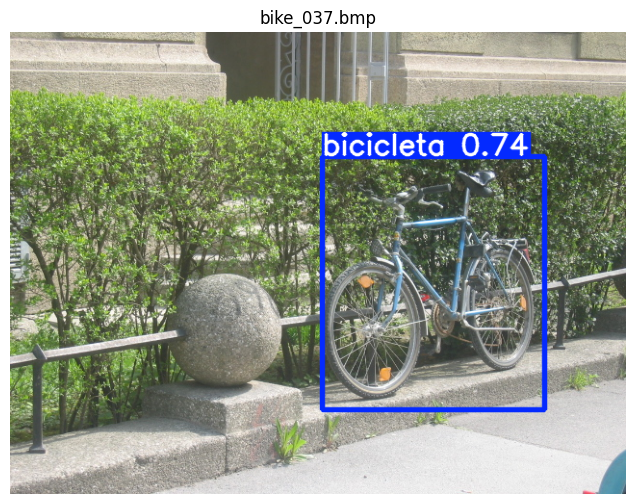

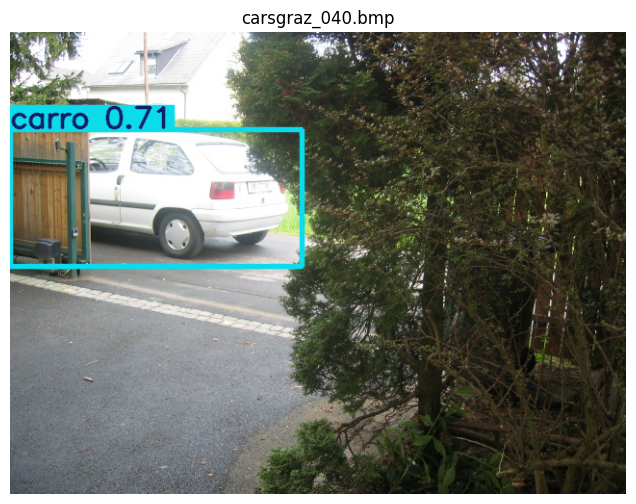

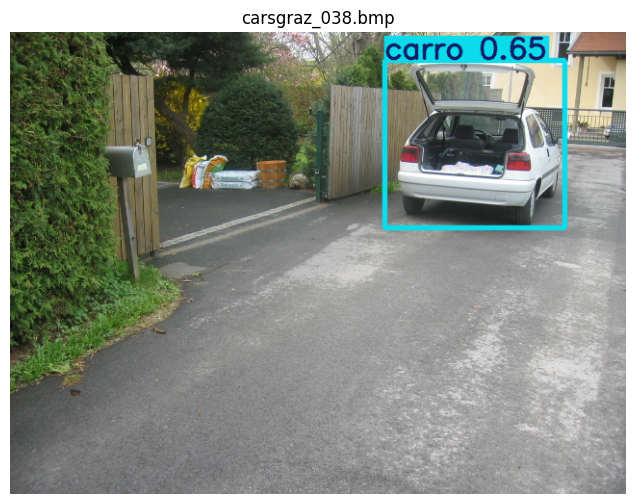

In [32]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

test_results_path = 'teste_final6' # aqui tem que ser trocado pelo diretório correto, a depender das tentativas de executação do teste anterior.

imgs = glob.glob(f'runs/detect/${test_results_path}/*.bmp')

for img_path in imgs:
    img = Image.open(img_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_path.split('/')[-1])
    plt.show()

### 📊 Análise dos Resultados de Teste

**Performance no conjunto de teste (8 imagens):**

**Taxa de Detecção Geral:** 7/8 objetos detectados (87.5%)

**Por Classe:**
- **Bicicletas:** 4/4 detectadas (100%) ✅
  - Todas as bicicletas foram corretamente identificadas
  - Confiança média alta (~0.7-0.8)
  
- **Carros:** 3/4 detectados (75%) ⚠️
  - 1 falha: carsgraz_039.bmp não foi detectado
  - Possível causa: ângulo, oclusão ou baixo contraste

**Observações:**
1. O modelo teve excelente performance em bicicletas (100%)
2. Carros tiveram 1 falso negativo (25% erro)
3. Não houve falsos positivos
4. Confiança das detecções: alta (>0.6)

**Casos de Sucesso:**
- Bicicletas detectadas corretamente mesmo com diferentes ângulos
- Carros identificados em cenários urbanos

**Limitações Identificadas:**
- 1 carro não detectado (investigar características da imagem)
- Dataset de teste pequeno (apenas 8 imagens)

**Conclusão:**
O modelo demonstrou boa generalização com 87.5% de acerto no teste,
validando os resultados de treinamento (mAP@0.5 de 99.5%).